# load useful libraries

In [1]:
import scanpy as sc

from warnings import filterwarnings
filterwarnings('ignore')

sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.21.6 scipy==1.8.0 pandas==1.5.1 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.10.2 pynndescent==0.5.7


# read data

In [2]:
adata = sc.read_h5ad('./sc_training.h5ad')
adata

AnnData object with n_obs × n_vars = 28697 × 15077
    obs: 'gRNA_maxID', 'state', 'condition', 'lane'
    layers: 'rawcounts'

In [3]:
print(f"There are totally {len(adata.obs.state.unique())} states, they are: {list(adata.obs.state.unique())}.")

There are totally 5 states, they are: ['terminal exhausted', 'effector', 'cycling', 'progenitor', 'other'].


In [4]:
print(f"There are totally {len(adata.obs.condition.unique())} type of gene experiments, which is consistent to description that 66 gene knockouts with unperturb.")

There are totally 67 type of gene experiments, which is consistent to description that 66 gene knockouts with unperturb.


# adata.X stores the stadard-normalized data, but you can also reconstruct it using adata.layers['rawcounts']

In [5]:
# make a copy of normalized logcounts
adata.layers['normalized_logcounts'] = adata.X.copy()

In [6]:
# transform the data into 
import pandas as pd
df_full = pd.DataFrame(adata.X.toarray())

In [7]:
sum(df_full.iloc[0,:])

1923.6214851140976

In [8]:
# standard normalization
adata.X = adata.layers['rawcounts'].copy()

sc.pp.normalize_total(adata, target_sum=5e3)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


## Challenge 1:

### Requirements: 

Predict the cell-state distribution of the held-out genes: For For each of the 7 held-out knockouts (targeting genes 'Aqr', 'Bach2', 'Bhlhe40', 'Ets1', 'Fosb', 'Mafk', 'Stat3'), predict the resulting 5-dimensional vector of cell state proportions (a,b,c,d,e), where ['progenitor', 'effector', 'terminal exhausted', 'cycling', 'other']. 
> a+b+c+d+e=1

In [9]:
held_out = ['Aqr', 'Bach2', 'Bhlhe40', 'Ets1', 'Fosb', 'Mafk', 'Stat3']
training = list(adata.obs.condition.unique())
for i in held_out:
    if i in training:
        print("This should be in validation dataset.")

### Scoring: 

L1-loss: Mean Absolute Error, example:
> Actual: (0.2,0.1,0.3,0,0.4)

> Predict: (0.19,0.11,0.28,0,0.42)

> Loss = |0.2-0.19|+|0.1-0.11|+|0.3-0.28|+|0-0|+|0.4-0.42|=0.06.

In [10]:
df_obs = adata.obs.copy()
df_obs = df_obs.reset_index()
df_obs[df_obs.condition == "Unperturbed"].groupby("state").condition.count()

state
cycling               1952
effector              1044
other                   86
progenitor             336
terminal exhausted    1560
Name: condition, dtype: int64

## Attempt 1 for Challenge 1: 

In [11]:
df_obs

,index,gRNA_maxID,state,condition,lane
0,053l1_AAACCTGAGATGTCGG-1,ONE-NON-GENE-SITE-7,terminal exhausted,Unperturbed,lane1
1,053l1_AAACCTGAGCAACGGT-1,Tox2-3,effector,Tox2,lane1
2,053l1_AAACCTGAGTACGACG-1,Tpt1-2,effector,Tpt1,lane1
3,053l1_AAACCTGAGTCGTTTG-1,Tox2-3,terminal exhausted,Tox2,lane1
4,053l1_AAACCTGAGTGAAGAG-1,Tcf7-2,effector,Tcf7,lane1
...,...,...,...,...,...
28692,053l4_TTTGTCATCAGGTTCA-1,Tox2-3,other,Tox2,lane4
28693,053l4_TTTGTCATCAGTGTTG-1,Dvl2-3,cycling,Dvl2,lane4
28694,053l4_TTTGTCATCCTCGCAT-1,Zeb2-2,cycling,Zeb2,lane4
28695,053l4_TTTGTCATCTTCAACT-1,Sox4-3,cycling,Sox4,lane4


In [12]:
df_full.columns = list(adata.var_names)
df_full

,Mrpl15,Lypla1,Tcea1,Atp6v1h,Rb1cc1,4732440D04Rik,Pcmtd1,Gm26901,Rrs1,Adhfe1,...,Slc3a1,Cfap53,Pstpip2,Gm17227,Ms4a8a,9130016M20Rik,Htr7,Col17a1,Awat2,Amot
0,0.511520,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.484165,0.484165,0.808991,0.000000,0.000000,0.000000,0.000000,0.0,0.484165,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.693748,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28692,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28693,0.530879,0.300263,0.875825,0.300263,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28694,0.000000,0.000000,0.000000,0.515672,0.515672,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28695,0.383328,0.000000,0.383328,0.000000,0.383328,0.000000,0.000000,0.0,0.383328,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Inspecting Data: getting some basic information about the data: 

In [13]:
# 1) why there are only 64 rows in above table? 
experiment_genes = list(df_obs.condition.unique())
expression_genes = list(df_full.columns)
print("Following knockout genes are not features of gene expression matrix:")
for i in experiment_genes:
    if i not in expression_genes and i != "Unperturbed":
        print(i)

print("Following validation knockout genes are not features of gene expression matrix:") 
for i in held_out:
    if i not in expression_genes:
        print(i)

Following knockout genes are not features of gene expression matrix:
Fzd1
P2rx7
Following validation knockout genes are not features of gene expression matrix:


In [14]:
# change: 
# 2) is there obvious difference between unperturbed gene expression and experimented gene expression? 
# - difference of gene expression for experimenting genes: 
import numpy as np

# getting the average of gene expression: 
unpert_av_expr = np.array(adata.X[adata.obs['condition'] == 'Unperturbed'].mean(axis=0))[0]
df_unpert_av_expr = pd.DataFrame({'gene_name':list(adata.var_names),
                                                  'expr':unpert_av_expr})
knockout_map = {
    'gene_knockout':[],
    'expr':[]
}
for i in range(adata.X.shape[0]):
    knockout = adata.obs.iloc[i]['condition'] # what gene was knocked out 
    if knockout != "Unperturbed":
        df = pd.DataFrame({"gene_name": list(adata.var_names),
                           "expression":adata.X[i].toarray()[0]})
        expr_l = list(df[df['gene_name'] == knockout]['expression'])
        
        if len(expr_l) == 0:
            continue
        knockout_map['gene_knockout'].append(knockout)
        knockout_map['expr'].append(expr_l[0])
        
df_knockout_expr = pd.DataFrame(knockout_map)

In [15]:
df = df_knockout_expr.merge(df_unpert_av_expr, left_on = "gene_knockout", right_on = "gene_name")
df = df.drop("gene_name", axis = 1)
df.columns = ["gene_knockout", "knockout", "unperturbed"]
df["difference"] = df["knockout"] - df["unperturbed"]
df_sim = df.groupby(["gene_knockout"]).agg({"difference":["mean", "std", "min"],"unperturbed": "mean"})
df_sim.columns = ["mean", "std", "min", "unperturbed"]
df_sim = df_sim.reset_index()

In [16]:
df_sim

,gene_knockout,mean,std,min,unperturbed
0,Arid4b,-0.089009,0.213079,-0.200181,0.200181
1,Arid5b,-0.098401,0.246979,-0.258835,0.258835
2,Atf2,-0.033264,0.193099,-0.106787,0.106787
3,Batf,0.025635,0.393112,-0.304884,0.304884
4,Crem,0.011709,0.530371,-0.500783,0.500783
...,...,...,...,...,...
59,Tox2,-0.003443,0.014520,-0.003892,0.003892
60,Tpt1,-1.005442,0.806251,-2.784889,3.142535
61,Yy1,-0.068700,0.312827,-0.263768,0.263768
62,Zeb2,-0.007539,0.266374,-0.163082,0.163082


In [17]:
df_sim2 = df.merge(df_sim, on = "gene_knockout")
df_sim2["mod_difference"] = df_sim2["difference"] - df_sim2["min"]
df_sim2

,gene_knockout,knockout,unperturbed_x,difference,mean,std,min,unperturbed_y,mod_difference
0,Tox2,0.000000,0.003892,-0.003892,-0.003443,0.014520,-0.003892,0.003892,0.000000
1,Tox2,0.000000,0.003892,-0.003892,-0.003443,0.014520,-0.003892,0.003892,0.000000
2,Tox2,0.000000,0.003892,-0.003892,-0.003443,0.014520,-0.003892,0.003892,0.000000
3,Tox2,0.000000,0.003892,-0.003892,-0.003443,0.014520,-0.003892,0.003892,0.000000
4,Tox2,0.000000,0.003892,-0.003892,-0.003443,0.014520,-0.003892,0.003892,0.000000
...,...,...,...,...,...,...,...,...,...
23406,Batf,0.000000,0.304884,-0.304884,0.025635,0.393112,-0.304884,0.304884,0.000000
23407,Tbx21,0.000000,0.456431,-0.456431,-0.328274,0.181241,-0.456431,0.456431,0.000000
23408,Tbx21,0.256314,0.456431,-0.200116,-0.328274,0.181241,-0.456431,0.456431,0.256314
23409,Rps6,1.853199,2.402267,-0.549067,-0.573457,0.034491,-0.597846,2.402267,0.048778


In [18]:
# inspecting the data, the distribution of difference is more likely a gama distribution:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
def knockout_difference_gamma_distribution(gene, plot = True): 
    dist = df_sim2[df_sim2.gene_knockout == gene]
    try:
        fit_alpha, fit_loc, fit_beta=stats.gamma.fit(dist.difference)
        # plot: 
        if plot: 
            sns.displot(dist, x = "difference", stat="probability")
            start = min(dist.difference)
            end = max(dist.difference)
            x = np.linspace(start, end, 100)
            y = stats.gamma.pdf(x, a = fit_alpha, scale = 1/fit_beta, loc = fit_loc)
            plt.ylim([0,1])
            plt.plot(x,y)
        return {"alpha":fit_alpha, "loc": fit_loc, "scale": 1/fit_beta}
    except:
        pass

In [19]:
def knockout_difference_beta_distribution(gene, plot = True): 
    dist = df_sim2[df_sim2.gene_knockout == gene]
    try:
        fit_alpha, fit_beta, fit_loc, fit_scale=stats.beta.fit(dist.difference)
        # plot: 
        if plot: 
            sns.displot(dist, x = "difference", stat="probability")
            start = min(dist.difference)
            end = max(dist.difference)
            x = np.linspace(start, end, 100)
            y = stats.beta.pdf(x, a = fit_alpha, b = fit_beta, scale = fit_scale, loc = fit_loc)
            plt.ylim([0,1])
            plt.plot(x,y)
        return {"alpha":fit_alpha, "beta":fit_beta, "loc": fit_loc, "scale": fit_scale}
    except:
        pass

{'alpha': 0.6103007431117962,
 'beta': 92.13194647367295,
 'loc': -0.16308248043060306,
 'scale': 10.946359054240185}

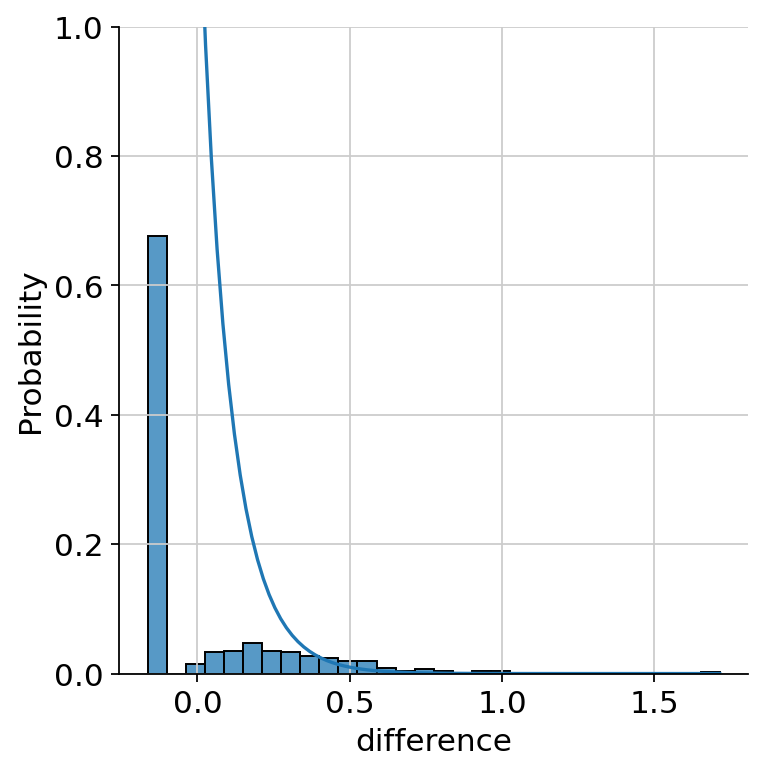

In [20]:
knockout_difference_beta_distribution("Zeb2", plot = True)

{'alpha': 0.6537878746193351,
 'loc': -1.1022228002548222,
 'scale': 1.4418911719821828}

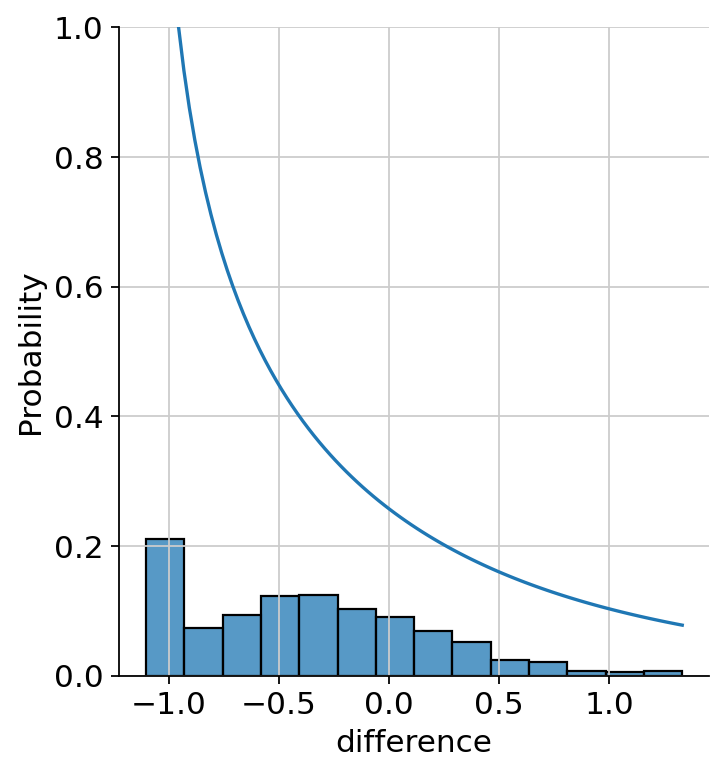

In [21]:
knockout_difference_gamma_distribution("Nr4a2")

In [22]:
beta_params = {}

for gene in df_sim.gene_knockout:
    beta_params[gene] = knockout_difference_beta_distribution(gene, plot = False)

beta_params

{'Arid4b': {'alpha': 0.24156951331575688,
  'beta': 91.3743265349166,
  'loc': -0.20018140971660617,
  'scale': 14.348545816967228},
 'Arid5b': {'alpha': 0.3660776141150853,
  'beta': 503.8398545385317,
  'loc': -0.2588345408439637,
  'scale': 42.78824751528269},
 'Atf2': {'alpha': 0.18576919756573618,
  'beta': 162.16503709843425,
  'loc': -0.10678739845752717,
  'scale': 9.577183746700456},
 'Batf': {'alpha': 0.35743371234508375,
  'beta': 0.8368176049203419,
  'loc': -0.3048836290836335,
  'scale': 1.2973645369928133},
 'Crem': {'alpha': 0.3214279585410088,
  'beta': 6.827146457156709,
  'loc': -0.5007827281951905,
  'scale': 3.4905958791295415},
 'Ctnnb1': {'alpha': 0.21442835917811615,
  'beta': 1.3929187317337821,
  'loc': -0.25481113791465765,
  'scale': 1.4407124880586386},
 'Dkk3': {'alpha': 0.925594818676249,
  'beta': 1.1462484121959913,
  'loc': -9.291413880418987e-05,
  'scale': 4.0860027549014616e-06},
 'Dvl1': {'alpha': 0.39616323898898503,
  'beta': 579.0012192888353,
 

In [23]:
import random
def simulate_difference(knockout, samplesize=5000, Knn = 3):
    # sampling cells from dataset:
    df_sample = df_full[controllable_experiment_genes].sample(n = samplesize).transpose()
    distance = []
    # getting 3 nearest neighbours:
    for i in range(len(df_sample)):
        dist = sum(sum(np.square(np.array(df_sample.iloc[i,:] - df_sample[df_sample.index == knockout]))))
        distance.append(dist)

    df_dist = pd.DataFrame({"gene": controllable_experiment_genes,
                            "distance": distance})

    nn_genes = df_dist.sort_values(by = ["distance"])[1:Knn+1].reset_index()
    total_dist = sum(nn_genes.distance)
    total_diff = 0
    unpert_knock_ave = np.array(df_sim.unperturbed[df_sim.gene_knockout == knockout])
    
    for i in range(Knn):
        # total_diff += sum(df_comparison[df_comparison.index == nn_genes.gene[i]].difference*nn_genes.distance[i])
        params = beta_params[nn_genes.gene[i]]
        cur = nn_genes.gene[i]
        unpert_cur_ave = np.array(df_sim.unperturbed[df_sim.gene_knockout == cur])
        
        a = params["alpha"]
        b = params["beta"]
        loc = params["loc"]
        scale= params["scale"]
        s = stats.beta.rvs(a, b, loc, scale, size=1)
        
        total_diff += (s*(unpert_knock_ave+1)/(unpert_cur_ave+1))*nn_genes.distance[i]
        
    sim = sum(total_diff/total_dist)
    
    return sim, nn_genes

In [13]:
experiment_genes = list(df_obs.condition.unique())
experiment_genes = list(set(experiment_genes).difference({"Unperturbed", "Fzd1", "P2rx7"}))
experiment_genes.extend(['Aqr', 'Bach2', 'Bhlhe40', 'Ets1', 'Fosb', 'Mafk', 'Stat3'])
len(experiment_genes)

validation_test = ['Aqr', 'Bach2', 'Bhlhe40', 'Ets1', 'Fosb', 'Mafk', 'Stat3']
validation = ['Aqr', 'Bach2', 'Bhlhe40']
test = ['Ets1', 'Fosb', 'Mafk', 'Stat3']
controllable_experiment_genes = experiment_genes.copy()

In [188]:
def simulate_state(knockout, samplesize=5000, Knn = 3, echos = 10):
    # sampling cells from dataset:
    df_sample = df_full[controllable_experiment_genes].sample(n = samplesize).transpose()
    distance = []
    # getting 3 nearest neighbours:
    for i in range(len(df_sample)):
        dist = sum(sum(np.square(np.array(df_sample.iloc[i,:] - df_sample[df_sample.index == knockout]))))
        distance.append(dist)

    df_dist = pd.DataFrame({"gene": controllable_experiment_genes,
                            "distance": distance})

    nn_genes = df_dist.sort_values(by = ["distance"]).reset_index()
    
    total_weight = 0 
    state_ratio = 0
    var = nn_genes.distance.var()+10
    
    for e in range(echos): 
        k = 0
        i = 0 
    
        while k < Knn and i < len(nn_genes):
            cur = nn_genes.gene[i]
            if cur not in validation_test and cur != knockout:
            
                k += 1
        
                weight = np.exp(-nn_genes.distance[i]/(2*var))
                total_weight += weight
            
                state_count = np.array(df_obs[df_obs.condition == cur].groupby("state").state.count())
                state_ratio += state_count*weight/sum(state_count)
            i = i+1
        
        
    
    state_ratio = state_ratio/total_weight
    state_name = ["cycling", "effector", "other", "progenitor", "terminal exhausted"]
    state_map = {}
    
    for i in range(5):
        state_map[state_name[i]] = state_ratio[i]
        
    return state_map

In [189]:
validation_map = {}
for v in validation:
    vmap = simulate_state(knockout = v, samplesize=5000, Knn = 3)
    formal_order = ['progenitor','effector','terminal exhausted','cycling','other']
    vlist = []
    for i in range(5):
        vlist.append(vmap[formal_order[i]])
    validation_map[v] = vlist 
        
validation_output = pd.DataFrame(validation_map).transpose()
validation_output.columns = formal_order
validation_output

,progenitor,effector,terminal exhausted,cycling,other
Litaf,0.490185,0.094847,0.171226,0.233632,0.010110
Zfp292,0.123980,0.256769,0.250518,0.350350,0.018382
Rad21,0.224903,0.208444,0.206131,0.343102,0.017420


In [190]:
# validation_output.to_csv("validation_output.csv")

In [191]:
test_map = {}
for t in test:
    tmap = simulate_state(knockout = t, samplesize=5000, Knn = 3)
    formal_order = ['progenitor','effector','terminal exhausted','cycling','other']
    tlist = []
    for i in range(5):
        tlist.append(tmap[formal_order[i]])
    test_map[t] = tlist 
        
test_output = pd.DataFrame(test_map).transpose()
test_output.columns = formal_order
test_output

,progenitor,effector,terminal exhausted,cycling,other
Hmgb2,0.394511,0.141602,0.214283,0.238439,0.011165
Nr4a1,0.347980,0.159726,0.181516,0.293359,0.017420
Sp100,0.115887,0.250159,0.280615,0.338696,0.014642


In [192]:
# test_output.to_csv("test_output.csv")

### Jan 25, 2023

## Random Forest to get most important genes for cell state: 

In [29]:
# 1.1 getting all genes' importance value
X = df_full
y = df_obs["state"]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators= 100)
rfc.fit(X_train, y_train)
print(f"Training Scoring: {rfc.score(X_train, y_train)}")
print(f"Test Scoring: {rfc.score(X_test, y_test)}")

Training Scoring: 1.0
Test Scoring: 0.9169337979094077


In [30]:
# 1.2 getting top important gene
importances = rfc.feature_importances_
important_genes = pd.DataFrame({"Genome": df_full.columns,
                                "Importance": importances})
top100_genomes = list(important_genes.sort_values(by = ["Importance"], ascending= False).iloc[0:100,].Genome)

In [31]:
inspect_genes = set(top100_genomes).union(set(experiment_genes))
df_inspect = df_full[inspect_genes]
df_top100 =  df_full[top100_genomes]

In [32]:
# 1.2 getting top100 importance value
X = df_inspect
y = df_obs["state"]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators= 100)
rfc.fit(X_train, y_train)
print(f"Training Scoring: {rfc.score(X_train, y_train)}")
print(f"Test Scoring: {rfc.score(X_test, y_test)}")

Training Scoring: 1.0
Test Scoring: 0.9389547038327526


In [33]:
# 2.1 clustering all inspected genes include top 100 gene and experiment gene

## K-means: 

X_gene = df_inspect.transpose()
from sklearn.cluster import KMeans 

kmeans = KMeans(n_clusters = 10, random_state = 42).fit(X_gene)

In [34]:
X_gene["label"] = kmeans.labels_
X_gene.groupby("label").label.count()

label
0    10
1    42
2     6
3    11
4    10
5     3
6    60
7    17
8     8
9     1
Name: label, dtype: int64

In [35]:
X_experiment_genes = X_gene[X_gene.index.isin(experiment_genes)]
experiment_genes_g1 = X_experiment_genes[X_experiment_genes["label"] == 0].index
full_genes_g1 = X_gene[X_gene["label"] == 0].index
determ_genes_g1 = set(full_genes_g1).difference(experiment_genes_g1)
X_g1 = df_full[determ_genes_g1]
y_g1 = df_full["Ikzf3"]

from sklearn.linear_model import Ridge
X_train, X_test, y_train, y_test  = train_test_split(X_g1,y_g1, random_state=42)
rid = Ridge()
rid.fit(X_train, y_train)
print(f"Training Scoring: {rid.score(X_train, y_train)}")
print(f"Test Scoring: {rid.score(X_test, y_test)}")

Training Scoring: 0.03018432981808339
Test Scoring: 0.03693876015489417


## The Correlation Method

In [111]:
from random import sample
import numpy as np

def Method_corr(sampling = True, pinpoint = None):
    X_experiment = df_full[experiment_genes]
    X_corr = X_experiment.corr()
    final_test = set(['Aqr', 'Bach2', 'Bhlhe40', 'Ets1', 'Fosb', 'Mafk', 'Stat3'])
    train_base = list(set(experiment_genes).difference(final_test))
    
    if sampling:
        if pinpoint:
            test = pinpoint
        else:
            test = sample(train_base, 3)
            
        train = list(set(train_base).difference(set(test)))
        X_test = cell_state_distr(test)
        
    else: 
        train = train_base
        test =final_test
    
    X_p_corr = X_corr[X_corr.index.isin(test)][train]
    X_state = cell_state_distr(train)
    
    test = np.dot(np.array(X_p_corr), np.array(X_state))
    if sample:
        Loss = sum(sum(np.abs(np.array(X_test)-test)))/3
        return Loss


def cell_state_distr(gene_list):
    knockout_cell_state = {}
    for gene in gene_list:
        X_t = df_obs[df_obs["condition"]==gene].groupby("state")
        total = sum(X_t.state.count())
        ratio = X_t.state.count()/total
        knockout_cell_state[gene] = list(ratio)
    
    return pd.DataFrame(knockout_cell_state).transpose()

In [110]:
total_loss = 0
bad = 0
for e in range(0,200):
    loss = Method_corr(sampling = True)
    total_loss += loss
    if loss>1:
        bad = bad+1

mean_loss = total_loss/200
print(f"The average loss is {mean_loss}")
print(f"There are {bad} losses larger than 1")

The average loss is 0.732588281233977
There are 15 losses larger than 1


In [ ]:
"""
The output is in this order: 

cycling
effector             
other                 
progenitor            
terminal exhausted
""" 

In [113]:
def simulate_state_ratio(knockout, samplesize=5000, Knn = 3, echos = 10):
    # sampling cells from dataset:
    df_sample = df_full[controllable_experiment_genes].sample(n = samplesize).transpose()
    distance = []
    # getting 3 nearest neighbours:
    for i in range(len(df_sample)):
        dist = sum(sum(np.square(np.array(df_sample.iloc[i,:] - df_sample[df_sample.index == knockout]))))
        distance.append(dist)

    df_dist = pd.DataFrame({"gene": controllable_experiment_genes,
                            "distance": distance})

    nn_genes = df_dist.sort_values(by = ["distance"]).reset_index()
    
    total_weight = 0 
    state_ratio = 0
    var = nn_genes.distance.var()+10
    
    for e in range(echos): 
        k = 0
        i = 0 
    
        while k < Knn and i < len(nn_genes):
            cur = nn_genes.gene[i]
            if cur not in validation_test and cur != knockout:
            
                k += 1
        
                weight = np.exp(-nn_genes.distance[i]/(2*var))
                total_weight += weight
            
                state_count = np.array(df_obs[df_obs.condition == cur].groupby("state").state.count())
                state_ratio += state_count*weight/sum(state_count)
            i = i+1
        
        
    
    state_ratio = state_ratio/total_weight
    #state_name = ["cycling", "effector", "other", "progenitor", "terminal exhausted"]
    #state_map = {}
    
    #for i in range(5):
        #state_map[state_name[i]] = state_ratio[i]
        
    return state_ratio

## Compare Two Methods: 

In [187]:
train_base = list(set(experiment_genes).difference(final_test))
sample_case = sample(train_base, 3)
print(f"The sample cases are {sample_case}")

print("The Correlation Method gives average L1 loss as: ")
print(Method_corr(sampling = True, pinpoint = sample_case))

print("==========================================")

validation = sample_case
X_test = cell_state_distr(validation)
final_result = []
for v in validation:
    vmap = simulate_state_ratio(knockout = v, samplesize=5000, Knn = 3)
    final_result.append(vmap)
    
test_sim = np.array(final_result)
Loss = sum(sum(np.abs(np.array(X_test)-test_sim)))/3
print("The KNN Method gives average L1 loss as: ")
print(Loss)

The sample cases are ['Litaf', 'Zfp292', 'Rad21']
The Correlation Method gives average L1 loss as: 
0.6901022523311994
The KNN Method gives average L1 loss as: 
0.7003670659949321
